# Figure 7
SEM statistics, with PSDs from the PCASP and CDP overlaid. This code has been adapted from code provided by Martin I. Daily.

In [1]:
# Standard Library
import os
from glob import glob
import datetime as dt

# Others
import pandas as pd
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib.collections import LineCollection
import matplotlib as mpl

import warnings
warnings.simplefilter("ignore", category=FutureWarning) # for FutureWarning only

import faamasd as asd

In [2]:
base = '/home/users/erinraif/acao_data/probe_calibration/'
pcasp_scattering_inputs = asd.pcasp_scattering_inputs
cdp_scattering_inputs = asd.cdp_scattering_inputs
cdp_channel_data_folder = base + 'channel_data_CDP'
pcasp_channel_data_folder = base + 'channel_data_PCASP'
attribute_file = base + 'attributes_for_calibration_arrays.txt' # Set to None if not present
pcasp_calibration = asd.produce_calibration_dataset(pcasp_channel_data_folder,pcasp_scattering_inputs,
                                                    attribute_file)
cdp_calibration = asd.produce_calibration_dataset(cdp_channel_data_folder,cdp_scattering_inputs,attribute_file)
pcasp_cal_at_ri = pcasp_calibration.sel(refractive_index = 1.56+0j)
cdp_cal_at_ri = cdp_calibration.sel(refractive_index = 1.56+0j)
timings_data = pd.read_csv(
    '/home/users/erinraif/acao_data/metadata/timings_of_filter_legs_acao.csv',
    index_col='unique_ID')
timings_data = timings_data[timings_data['psd_available'] == True]
timings_data = timings_data.drop(['c276r3t','c278r3t'])
leg_types = pd.read_csv('/home/users/erinraif/acao_data/metadata/filter_leg_types.csv',
                        index_col='unique_ID')
def get_timings(metadata_row):
    """Retrieve filter run timings, including pauses.
    
    Returns a list of consecutive times as ints in SPM. This is in the format
    [start, (pause1 start), (pause1 end), ..., end]
    where pauses are only present where necessary.
    
    Parameters
    ----------
    metadata_row: pandas Series
        row of the metadata pandas dataframe
    
    Returns
    -------
    list of ints
        times in SPM of run events
    """
    leg_start_times = [metadata_row.start_time]
    leg_end_times = [metadata_row.end_time]
    pauses = metadata_row.no_pauses
    for i in range(pauses):
        start_str = 'metadata_row.pause' + str(i+1) + '_end'
        end_str = 'metadata_row.pause' + str(i+1) + '_start'
        leg_start_times.append(eval(start_str))
        leg_end_times.insert(i, eval(end_str))
    return leg_start_times, leg_end_times

In [3]:
def get_sem_data(filter_name, chromium_filter=False):
    # Path to high and low mag input file (eg c301p1hm)
    # containing SEM particle size (ECD) and class as determined
    # by algorithm in Sanchez-Marroquin, et al. 2023
    dfh = pd.read_csv(rf'/home/users/erinraif/acao_data/sem_data/{filter_name}hm.csv') # High mag data
    dfl = pd.read_csv(rf'/home/users/erinraif/acao_data/sem_data/{filter_name}lm.csv') # Low mag data

    # Screens out particles outside the size ranges we want and makes sure the two datasets don't overlap.
    dfh_filtered = dfh[dfh['ECD (um)'].between(0.3, 0.8)]
    dfl_filtered = dfl[dfl['ECD (um)'].between(0.8, 30)]

    if chromium_filter:
    # Screens out metallic Cr, which may be contamination from the microscope
        dfh_filtered = dfh_filtered[~dfh_filtered['Class'].str.contains('Metallic Cr', case=False)]
        dfl_filtered = dfl_filtered[~dfl_filtered['Class'].str.contains('Metallic Cr', case=False)]

    df = pd.concat([dfh_filtered, dfl_filtered], ignore_index=True)
    return df
    

In [4]:
def apply_SM_classes(df, SM_ID, particle_classes):
    condition = df['Class'].isin(particle_classes)
    
    # Create a new column 'SM_Classes' and assign '8. Carbonaceous' where the condition is True
    df.loc[condition, 'SM_Class'] = SM_ID
    
    # Return the modified DataFrame
    return df

In [5]:
# Sanchez-Marroquin categories:
SM_categories = {
    '1. Mineral: Si rich': ['Sillica mixtures '],
    '2. Mineral: Si only': ['Sillica', 'False Si '],
    '3. Mineral: Al-Si rich': ['Aluminosillicates'],
    '4. Ca-rich' : ['Ca rich', 'Gypsium', 'Ca pure'],
    '5. Sea aerosol*' :
        ['Aluminosillicates+NaCl','Silica mixtures +NaCl',
            'Ca rich+NaCl', 'Aged Sea Aerosol', 'Sea aerosol',
            'Sea aerosol (Cl)'],
    '6. Metal rich' : ['Metallic Cr', 'Metallic Cu', 'Metallic Al',
                      'Metallic Ti', 'Metallic Zn','Metallic Fe',
                      'Metallic Pb', 'Metallic other'],
    '7. Sulphate and S-rich': ['Sulfate aerosol'],
    '8. Carbonaceous' : ['Oxygen only', 'P rich', 'Oxygen +K',
                         'Mainly O', 'Oxigen+Cu(trace)'],
    '9. Cl rich' : ['Cl', 'Cl+K'],
    '0. Unclassified' : ['No Classification','nan']
    }
# Sets the colours of the bar chart, colours and their order taken from Alberto's paper
color_mapping = {
    '1. Mineral: Si rich': '#B4B574',
    '2. Mineral: Si only': '#E9E38D',
    '3. Mineral: Al-Si rich': '#F9A02C',
    '4. Ca-rich': '#F9A165',    
    '5. Sea aerosol*': '#678CC8',
    '6. Metal rich': '#B12C28',
    '7. Sulphate and S-rich': '#EFE92A',
    '8. Carbonaceous': '#1E8843',
    '9. Cl rich':'#e580ff',  
    '0. Unclassified':'#CACBCD',  
}

In [7]:
areadf = pd.read_csv(r'/home/users/erinraif/acao_data/sem_data/semareas.csv')

# Shouldn't need changing
total_filter_area = 7.07e8

In [8]:
def get_probe_data_for_filter(filter_name):
    for run in timings_data.itertuples():
        if run.Index == filter_name[:4]+'r'+filter_name[-1]+'t':
        # Get the correct datasets for the run and and merge them 
            core_cloud_data_fn = glob(os.path.join(
                '/badc/faam/data/2022',run.flight + '*/core_processed',run.core_cloud
            ))[0]
            core_data_fn = glob(os.path.join(
                '/badc/faam/data/2022',run.flight + '*/core_processed',run.core_faam
            ))[0]
            nev_data_fn = '/home/users/erinraif/acao_data/nevzorov_data/' + run.nev_data
            flight_data = asd.get_data(core_cloud_data_fn, core_data_fn)
        
            # Make Nevzorov cloud-flag data compatible with other datasets
            nev_ds = xr.open_dataset(nev_data_fn, engine='netcdf4',decode_times=False)
            nev_ds = nev_ds.rename_dims({'TIME': 'time'})
            nev_ds = nev_ds.rename({'TIME': 'time'})
            nev_flag = nev_ds.CLRFLG_COMBINED
        
            # Get timings for each run and clip data appropriately
            leg_start_times, leg_end_times = get_timings(run)
            nev_flag = asd.time_slice_data(leg_start_times, leg_end_times, nev_flag)
            uncorrected_pcasp, corrected_pcasp, pcasp_flow = asd.get_pcasp_data_for_leg(flight_data, leg_start_times, leg_end_times)
            pcasp_psds = asd.get_mean_log_psds(pcasp_cal_at_ri, uncorrected_pcasp, corrected_pcasp, pcasp_flow)
            uncorrected_cdp, corrected_cdp, cdp_flow = asd.get_cdp_data_for_leg(flight_data, leg_start_times, leg_end_times)
            rh_liq = asd.time_slice_data(leg_start_times, leg_end_times, flight_data['RH_LIQ'])
            
            # Apply humidity mask and Nevzorov cloud-presence mask
            rh_mask = rh_liq < 80
            nev_mask = nev_flag > 0.5
            comb_mask = rh_mask & nev_mask
            comb_uncorrected_cdp = uncorrected_cdp.where(comb_mask,drop=True)
            comb_corrected_cdp = corrected_cdp.where(comb_mask, drop=True)
        
            # Get mean particle size distributions during each leg
            comb_cdp_psds = asd.get_mean_log_psds(cdp_cal_at_ri, comb_uncorrected_cdp, comb_corrected_cdp, cdp_flow)
    return pcasp_psds, comb_cdp_psds
    

In [9]:
def collate_sem_stats(filter_name, bin_edges):

    lowmagarea = areadf.loc[areadf['data']==filter_name+'lm'].values[0,1] # um2
    highmagarea = areadf.loc[areadf['data']==filter_name+'hm'].values[0,1] # um2
    vol = areadf.loc[areadf['data']==filter_name+'hm'].values[0,2] * 1000 # cm3

    df = get_sem_data(filter_name, True)
    for cat in SM_categories:
        df = apply_SM_classes(df, cat, SM_categories[cat])
    mag_boundary = np.where(bin_edges == 0.8)[0][0]
    
    #Counts and sorts particles into categories. 
    totalhist, _ = np.histogram(df['ECD (um)'], bins=bin_edges)
    totalparticles = np.sum(totalhist)
    ddf = pd.DataFrame({'bin_midpoint':(bin_edges[:-1]+bin_edges[1:])/2})
    ddf = ddf.set_index('bin_midpoint')
    # Generates a dataframe (ddf) of particle diameter in each size bin for each category
    for i in SM_categories:
        cat_df = df[df['SM_Class']==i]
        diameter =((cat_df['ECD (um)']))
        hist_values, _ = np.histogram(diameter, bins=bin_edges)
        ddf[i] = hist_values
    
    # Count the occurrences of each category
    class_counts = df['SM_Class'].value_counts()
    
    # This calculates the propotional composition for each size bin 
    ddf_proportions = ddf.div(ddf.sum(axis=1), axis=0)
    ddf_proportions.index = np.around(ddf_proportions.index,2)
    # Use regex to take only coolumns for categories 1-4 to retrieve mineral fraction
    ddf_mineral = ddf_proportions.filter(regex='^[1-4]', axis=1).sum(axis=1)

    dN_h = totalhist[:mag_boundary]/(vol*(highmagarea/total_filter_area))
    dN_l = totalhist[mag_boundary:]/(vol*(lowmagarea/total_filter_area))
    dN = np.concatenate((dN_h,dN_l),axis=0)
    dndlogdp = dN/np.diff(np.log10(bin_edges))
    return ddf, ddf_proportions, dndlogdp

In [10]:
def custom_formatter(x, pos):
    if x < 1:
        return "{:.1f}".format(x)
    else:
        return int(x)

In [11]:
pcasp1, cdp1 = get_probe_data_for_filter('c279p1')
pcasp2, cdp2 = get_probe_data_for_filter('c278p2')

c279p1 S 3.7589099569065428e-06 1.2117148978765678e-06
c278p2 S 1.5987822535287982e-06 8.534282268999206e-07


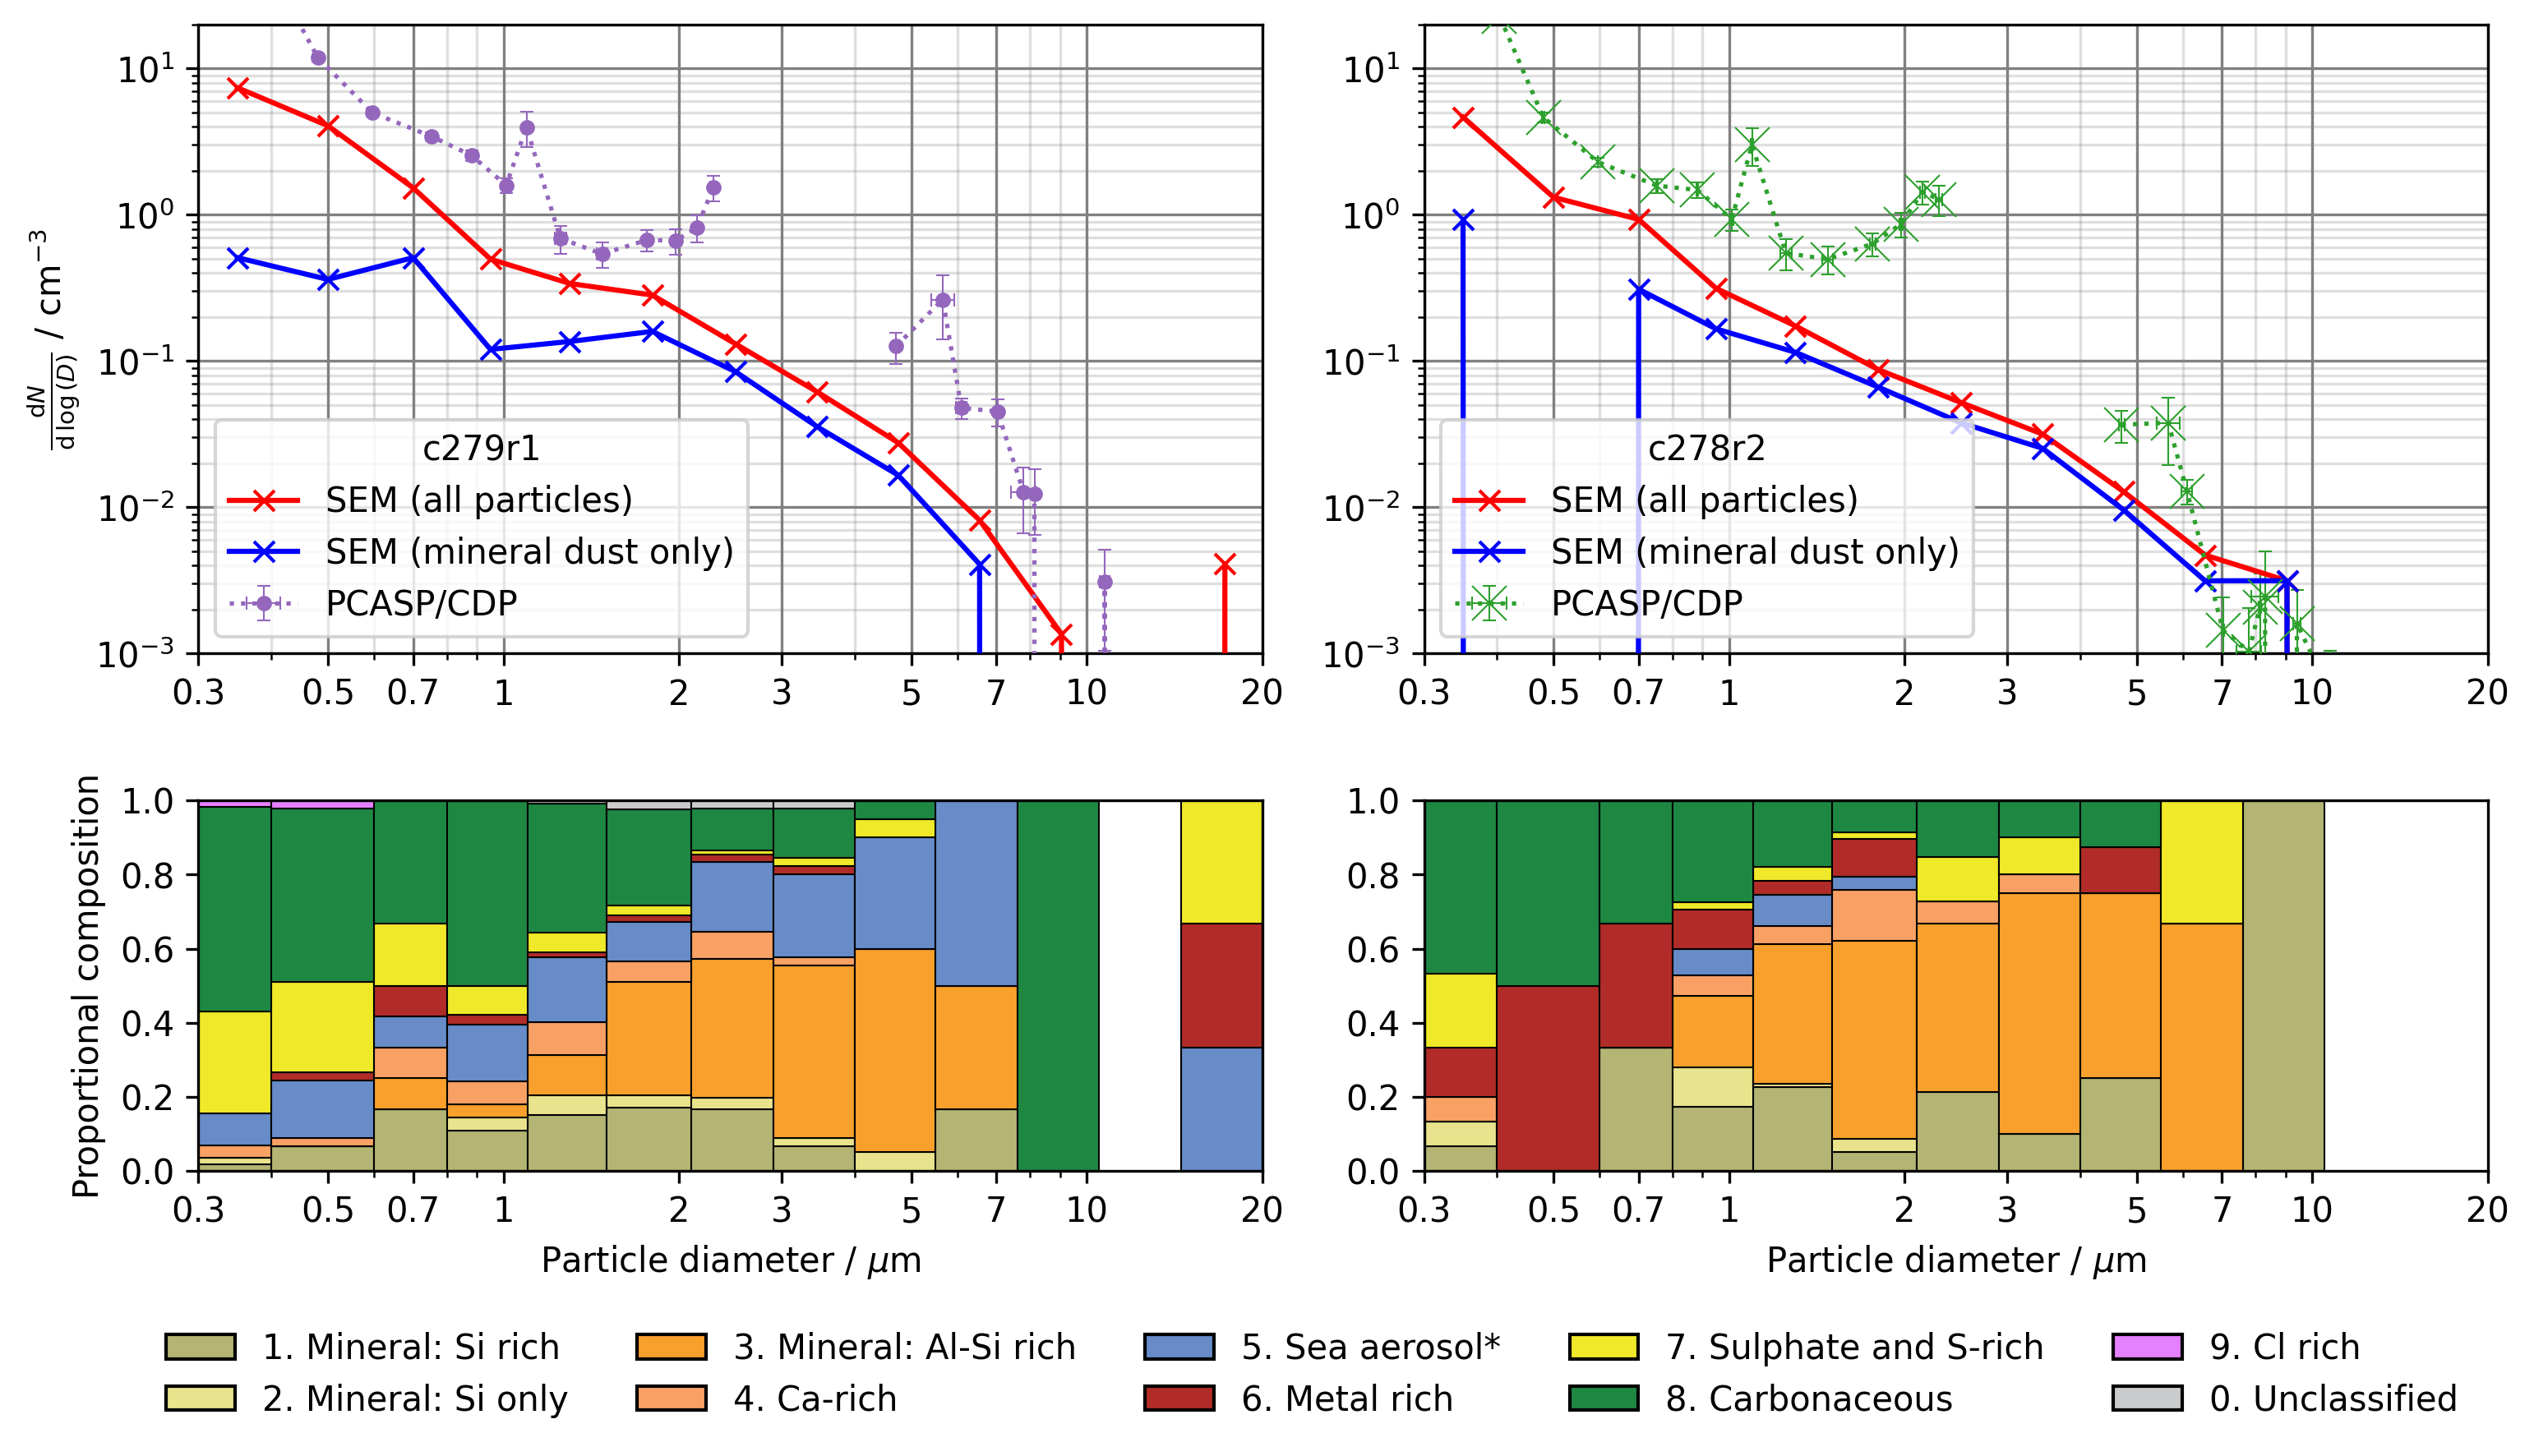

In [12]:
# Plots the stacked bar chart of proportional composition
bin_edges = np.array([ 0.3,  0.4,  0.6,  0.8 , 1.1 , 1.5 , 2.1 , 2.9,  4 ,  5.5 , 7.6,10.5, 14.5, 20 ])
mosaic = [
    ["size1", "size1", "size1", "size2", "size2", "size2"],
    ["size1", "size1", "size1", "size2", "size2", "size2"],
    ["size1", "size1", "size1", "size2", "size2", "size2"],
    ["comb1", "comb1", "comb1", "comb2", "comb2", "comb2"],
    ["comb1", "comb1", "comb1", "comb2", "comb2", "comb2"],
    ["dummy", "dummy", "dummy", "dummy", "dummy", "dummy"]
]

fig, axes = plt.subplot_mosaic(mosaic,figsize=(11,6),dpi=300)

# Kwargs to work with faamasd function to plot PSD
kwargs1 = dict(linewidth=1.25,marker='o',elinewidth=0.5,markersize=4,capsize=2,
              markeredgewidth=0.5,capthick=0.25,xlim=[0.3,20],ylim=[0.001,20],
              xlabel=None,zorder=4,color='tab:purple',linestyle='dotted',
              label='PCASP/CDP')
kwargs2 = dict(linewidth=1.25,marker='x',elinewidth=0.5,markersize=10,capsize=2,
              markeredgewidth=0.5,capthick=0.25,xlim=[0.3,20],ylim=[0.001,20],
              xlabel=None,ylabel=None,zorder=4,color='tab:green',linestyle='dotted',
              label='PCASP/CDP')
# Plot PSDs
axes['size1'] = asd.plot_dNdlogD(axes['size1'], pcasp1.sel(bin=slice(2,29)), False,
                                **kwargs1)
kwargs1['label']=None
axes['size1'] = asd.plot_dNdlogD(axes['size1'], cdp1, False, **kwargs1)
axes['size2'] = asd.plot_dNdlogD(axes['size2'], pcasp2.sel(bin=slice(2,29)), False, 
                                 **kwargs2)
kwargs2['label']=None
axes['size2'] = asd.plot_dNdlogD(axes['size2'], cdp2, False, **kwargs2)    
# Get SEM stats and print sum of total SEM surface area and mineral dust surface area
ddf1, ddfp1, dNdlogd1 = collate_sem_stats('c279p1',bin_edges)
ddf_m1 = ddfp1.filter(regex='^[1-4]', axis=1).sum(axis=1)
ds1 = dNdlogd1 * np.diff(np.log10(bin_edges)) * np.pi * ddf1.index.values**2 * 1e-6
ds_min1 = ds1 * ddf_m1
print('c279p1', 'S', ds1.sum(axis=0), ds_min1.sum(axis=0))
ddf2, ddfp2, dNdlogd2 = collate_sem_stats('c278p2',bin_edges)
ddf_m2 = ddfp2.filter(regex='^[1-4]', axis=1).sum(axis=1)
ds2 = dNdlogd2 * np.diff(np.log10(bin_edges)) * np.pi * ddf2.index.values**2 * 1e-6
ds_min2 = ds2 * ddf_m2
print('c278p2', 'S', ds2.sum(axis=0), ds_min2.sum(axis=0))
# Add size dstributions to plots
axes['size1'].plot(ddf1.index, dNdlogd1, marker='x', linestyle='-', color='red', label='SEM (all particles)',zorder=4)
axes['size2'].plot(ddf2.index, dNdlogd2, marker='x', linestyle='-', color='red', label='SEM (all particles)',zorder=4)
axes['size1'].plot(ddf1.index, dNdlogd1*ddf_m1, marker='x', linestyle='-', color='blue', label='SEM (mineral dust only)',zorder=4)
axes['size2'].plot(ddf2.index, dNdlogd2*ddf_m2, marker='x', linestyle='-', color='blue', label='SEM (mineral dust only)',zorder=4)
axes['size1'].legend(fontsize=10,title='c279r1',title_fontsize=10)
axes['size2'].legend(fontsize=10,title='c278r2',title_fontsize=10)
# Create bar chart with proportions of each particle
bottoms1 = bottoms2 = [0] * len(ddfp1.index)
for i, col in enumerate(ddfp1.columns):
    axes['comb1'].bar(ddfp1.index, ddfp1[col],
           width=np.diff(bin_edges), bottom=bottoms1, label=col,
           color=color_mapping[col],edgecolor='k',linewidth=0.5)
    bottoms1 += ddfp1[col]
    axes['comb2'].bar(ddfp2.index, ddfp2[col],
           width=np.diff(bin_edges), bottom=bottoms2, label=col,
           color=color_mapping[col],edgecolor='k',linewidth=0.5)
    bottoms2 += ddfp2[col]
    axes['dummy'].add_patch(mpatches.Rectangle((-2,-2),width=1,height=1,
                                              label=col,
                                              facecolor=color_mapping[col],
                                              edgecolor='k'))

axes['comb1'].set_ylabel('Proportional composition')
axes['comb1'].set_xlabel(r'Particle diameter / $\mu$m')
axes['comb2'].set_xlabel(r'Particle diameter / $\mu$m')

for ax in ['size1','size2','comb1','comb2']:
    axes[ax].set_xlim(0.3,20)
    axes[ax].set_xscale('log')
    axes[ax].xaxis.set_major_formatter(mticker.FuncFormatter(custom_formatter))
    axes[ax].set_xticks([0.3, 0.5, 0.7, 1, 2, 3, 5, 7, 10, 20])

# Make dummy axes invisible and add legend.
axes['dummy'].spines['top'].set_visible(False)
axes['dummy'].spines['right'].set_visible(False)
axes['dummy'].spines['bottom'].set_visible(False)
axes['dummy'].spines['left'].set_visible(False)
axes['dummy'].tick_params(axis='both', which='both', bottom=False, 
                   left=False, labelbottom=False, labelleft=False)
axes['dummy'].set_xlim(1,2)
axes['dummy'].set_ylim(1,2)
axes['dummy'].legend(ncols=5, fontsize=10,loc='upper left',frameon=False,borderaxespad=0,
                    bbox_to_anchor=(-0.02,1))

fig.tight_layout()
fig.savefig('./imgs/f07.pdf')